# Aaron, SVM

In [1]:
from perform_kickstarer_eda import X_train, X_test, y_train, y_test

ks_data shape: (20632, 68)
Categorical columns: ['country', 'currency', 'deadline', 'state_changed_at', 'created_at', 'launched_at', 'category', 'deadline_weekday', 'state_changed_at_weekday', 'created_at_weekday', 'launched_at_weekday', 'launch_to_deadline', 'launch_to_state_change']
Converted boolean column: staff_pick
Dropped 'state_changed_at_weekday' column
Dropping original column: category
Encoded column: category → 25 features
Dropping original column: deadline_weekday
Encoded column: deadline_weekday → 7 features
Dropping original column: created_at_weekday
Encoded column: created_at_weekday → 7 features
Dropping original column: launched_at_weekday
Encoded column: launched_at_weekday → 7 features
Total categorical columns after encoding: 54


SVC_RBF: 0.9284891434025291 (0.00732342494176012)
SVC_POLY: 0.9258222931923721 (0.006893696739990794)


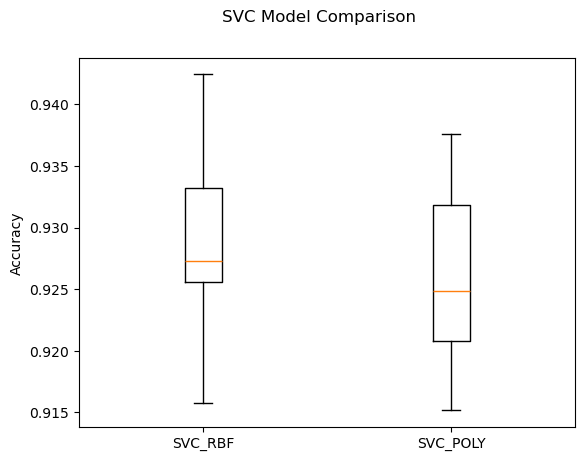

In [2]:
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from matplotlib import pyplot
from sklearn.model_selection import cross_val_score

# Default Settings
def evaluate_svc_models(models, X, y):
    results = []
    names = []
    for name, model in models:
        kfold = KFold(n_splits=10, shuffle=True, random_state=42)
        cv_results = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
        results.append(cv_results)
        names.append(name)
        print(f"{name}: {cv_results.mean()} ({cv_results.std()})")
    fig = pyplot.figure()
    fig.suptitle('SVC Model Comparison')
    ax = fig.add_subplot(111)
    pyplot.boxplot(results, tick_labels=names)
    ax.set_ylabel('Accuracy')
    pyplot.show()


models = []

svc_rbf_model = SVC(kernel='rbf', C=1.0, random_state=42)
svc_poly_model = SVC(kernel='poly', degree=2, C=1.0, random_state=42)

models.append(('SVC_RBF', svc_rbf_model))
models.append(('SVC_POLY', svc_poly_model))
evaluate_svc_models(models, X_train, y_train)

Tuning hyperparameters for: SVC_RBF
Best params for SVC_RBF: {'C': 10, 'gamma': 'scale'}
Best CV accuracy: 0.9310
F1 Score for SVC_RBF: 0.8826


NameError: name 'cross_val_scoring' is not defined

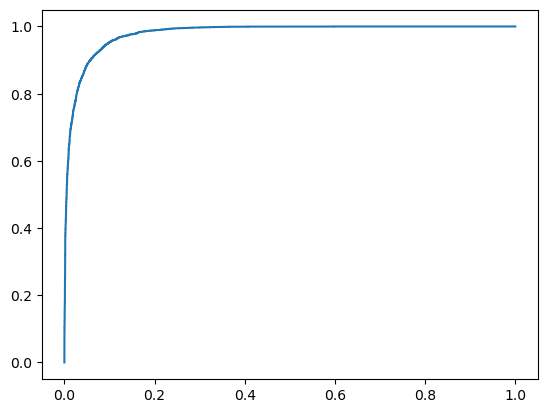

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import f1_score, roc_curve, auc
from matplotlib import pyplot as plt

def evaluate_svc_models(models, X, y):
    results = []
    names = []
    for name, _ in models:
        print(f"Tuning hyperparameters for: {name}")
        kfold = KFold(n_splits=10, shuffle=True, random_state=42)

        if name == 'SVC_RBF':
            param_grid = {
                'C': [0.1, 1, 10],
                'gamma': ['scale', 'auto', 0.01, 0.1]
            }
            model = SVC(kernel='rbf', random_state=42, probability=True)

        elif name == 'SVC_POLY':
            param_grid = {
                'C': [0.1, 1, 10],
                'degree': [2, 3, 4],
                'gamma': ['scale', 'auto']
            }
            model = SVC(kernel='poly', random_state=42, probability=True)

        elif name == 'SVC_LINEAR': # Added
            param_grid = {
                'C': [0.1, 1, 10],
                'tol': [1e-4, 1e-3]
            }
            model = SVC(kernel='linear', random_state=42, probability=True)

        elif name == 'SVC_SIGMOID': # Added
            param_grid = {
                'C': [0.1, 1, 10],
                'gamma': ['scale', 'auto']
            }
            model = SVC(kernel='sigmoid', random_state=42, probability=True)

        else:
            continue

        grid = GridSearchCV(model, param_grid, cv=kfold, scoring='accuracy', n_jobs=-1)
        grid.fit(X, y)
        best_model = grid.best_estimator_


        # Best parameters
        print(f"Best params for {name}: {grid.best_params_}")
        print(f"Best CV accuracy: {grid.best_score_:.4f}")

        # F1 Score
        y_pred = cross_val_predict(best_model, X, y, cv=kfold)
        f1 = f1_score(y, y_pred)
        print(f"F1 Score for {name}: {f1:.4f}")

        # ROC Curve
        y_scores = cross_val_predict(best_model, X, y, cv=kfold, method='predict_proba')[:, 1]
        fpr, tpr, _ = roc_curve(y, y_scores)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

        # Evaluate best estimator using cross_val_score
        cv_results = cross_val_score(best_model, X, y, cv=kfold, scoring='accuracy')
        results.append(cv_results)
        names.append(name)

        print(f"F1 Score: {f1:.4f} | AUC: {roc_auc:.4f}")
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

    # Plot results
    fig = plt.figure()
    fig.suptitle('Tuned SVC Model Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results, labels=names)
    ax.set_ylabel('Accuracy')
    plt.show()

# You still pass in model names (the second item is ignored)
models = [('SVC_RBF', None), ('SVC_POLY', None), ('SVC_LINEAR', None), ('SVC_SIGMOID', None)]
evaluate_svc_models(models, X_train, y_train)
